# Analysis of Surface Fields

`mom6_tools.MOM6grid` returns an object with MOM6 grid data.

`mom6_tools.latlon_analysis` has a collection of tools used to perform spatial analysis  (e.g., time averages and spatial mean).

The goal of this notebook is the following:

1) server as an example of how to post-process CESM/MOM6 output;

2) create time averages of surface fields;

3) create time-series of globally-averaged surface fields;

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings, os, yaml, argparse
import pandas as pd
import dask, intake
from datetime import datetime, date
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools.m6toolbox import add_global_attrs
from mom6_tools.m6plot import xycompare, xyplot
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.surface import get_SSH, get_MLD, get_BLD

warnings.filterwarnings("ignore")

/glade/work/gmarques/miniconda/envs/dev2/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

# load avg dates
avg = diag_config_yml['Avg']

# Create the case instance
dcase = DiagsCase(diag_config_yml['Case'])
DOUT_S = dcase.get_value('DOUT_S')
if DOUT_S:
  OUTDIR = dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/'
else:
  OUTDIR = dcase.get_value('RUNDIR')+'/'

print('Output directory is:', OUTDIR)
print('Casename is:', dcase.casename)

Output directory is: /glade/scratch/gmarques/archive/g.e23_b15.GJRAv4.TL319_t232_zstar_N65.baseline.001/ocn/hist/
Casename is: g.e23_b15.GJRAv4.TL319_t232_zstar_N65.baseline.001


In [4]:
# The following parameters must be set accordingly
######################################################

# create an empty class object
class args:
  pass

args.start_date = avg['start_date']
args.end_date = avg['end_date']
args.casename = dcase.casename
args.native = dcase.casename+diag_config_yml['Fnames']['native']
args.static = dcase.casename+diag_config_yml['Fnames']['static']
args.mld_obs = "mld-deboyer-tx2_3v2"
args.savefigs = False
args.nw = 6 # requesting 6 workers

In [5]:
if not os.path.isdir('PNG/BLD'):
  print('Creating a directory to place figures (PNG/BLD)... \n')
  os.system('mkdir -p PNG/BLD')
if not os.path.isdir('PNG/MLD'):
  print('Creating a directory to place figures (PNG/MLD)... \n')
  os.system('mkdir -p PNG/MLD')
if not os.path.isdir('ncfiles'):
  print('Creating a directory to place netcdf files (ncfiles)... \n')
  os.system('mkdir ncfiles')    

In [6]:
parallel = False
if args.nw > 1:
  parallel = True
  cluster = NCARCluster(interface='ext')
  cluster.scale(args.nw)
  client = Client(cluster)
  client

In [7]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high_memory/proxy/46835/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high_memory/proxy/46835/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.40:39182,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high_memory/proxy/46835/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
# load mom6 grid
grd = MOM6grid(OUTDIR+args.static)
grd_xr = MOM6grid(OUTDIR+args.static, xrformat=True)

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 



In [9]:
print('Reading native dataset...')
startTime = datetime.now()

def preprocess(ds):
  ''' Compute montly averages and return the dataset with variables'''
  variables = ['oml','mlotst','tos','SSH', 'SSU', 'SSV', 'speed', 'time_bnds']
  for v in variables:
    if v not in ds.variables:
      ds[v] = xr.zeros_like(ds.SSH)
  return ds[variables]

ds1 = xr.open_mfdataset(OUTDIR+args.native, parallel=parallel)
ds = preprocess(ds1)

print('Time elasped: ', datetime.now() - startTime)

Reading native dataset...
Time elasped:  0:03:41.482479


In [10]:
print('Selecting data between {} and {}...'.format(args.start_date, args.end_date))
ds_sel = ds.sel(time=slice(args.start_date, args.end_date))

Selecting data between 0031-01-01 and 0062-01-01...


In [11]:
catalog = intake.open_catalog(diag_config_yml['oce_cat'])
mld_obs = catalog[args.mld_obs].to_dask()
# uncomment to list all datasets available
#list(catalog)

### Mixed layer depth

Computing monthly MLD climatology...
Time elasped:  0:01:22.563966

 Plotting...


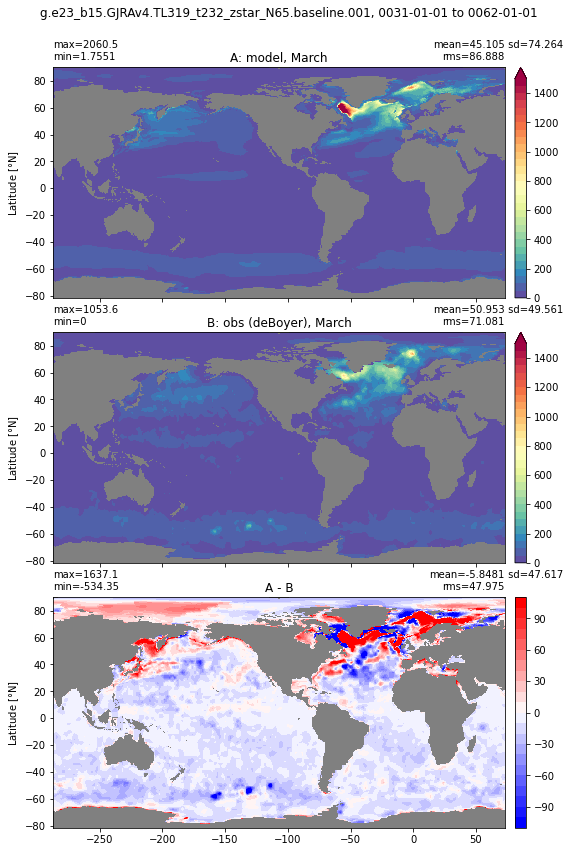

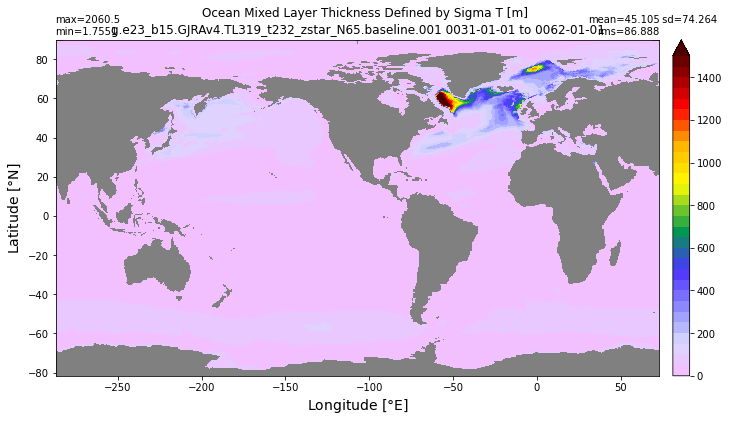

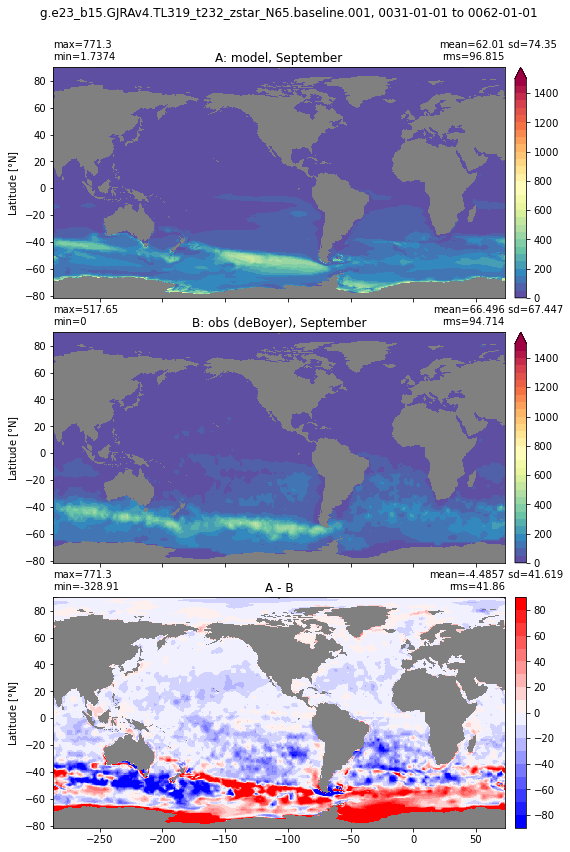

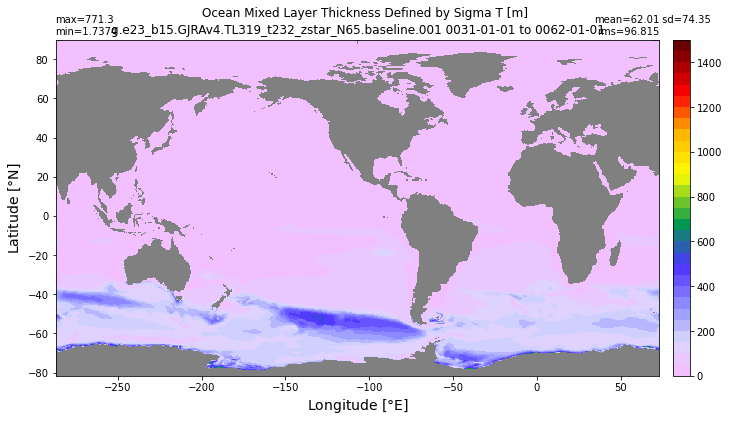

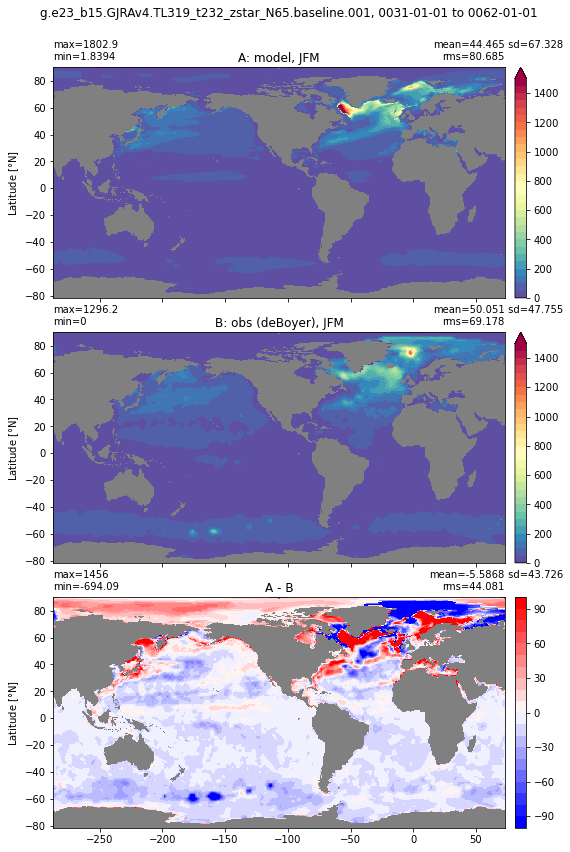

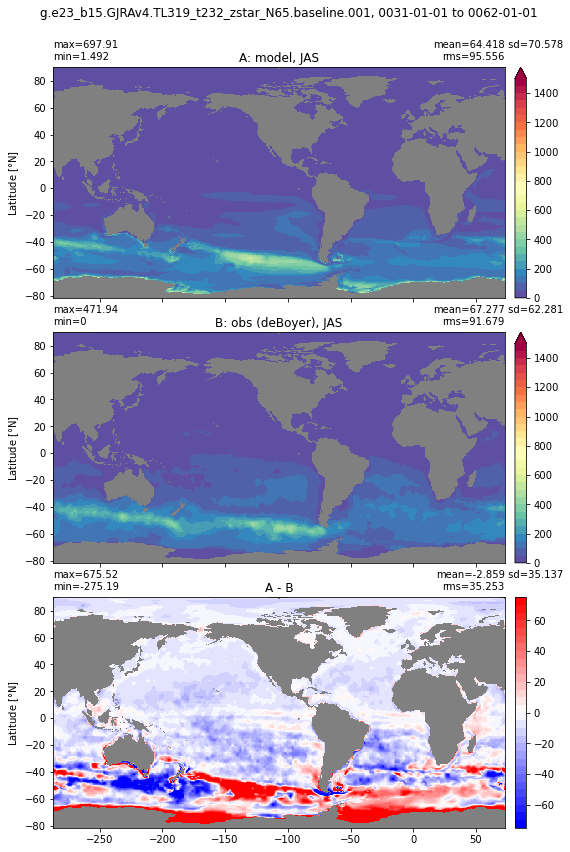

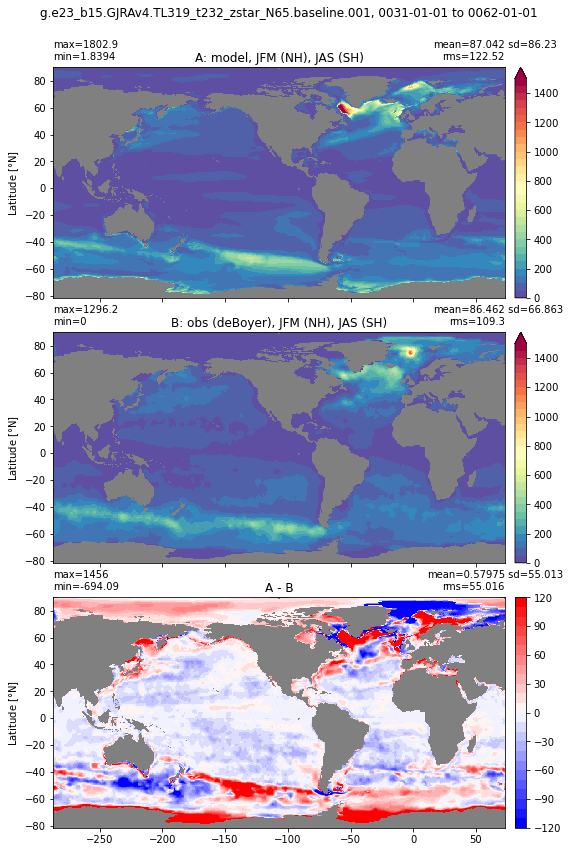

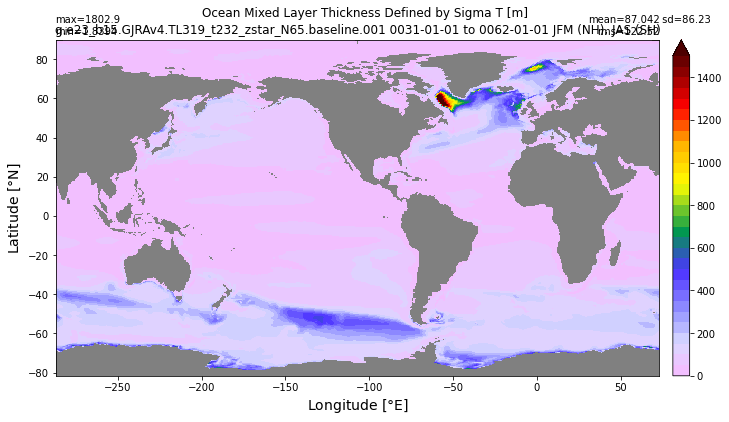

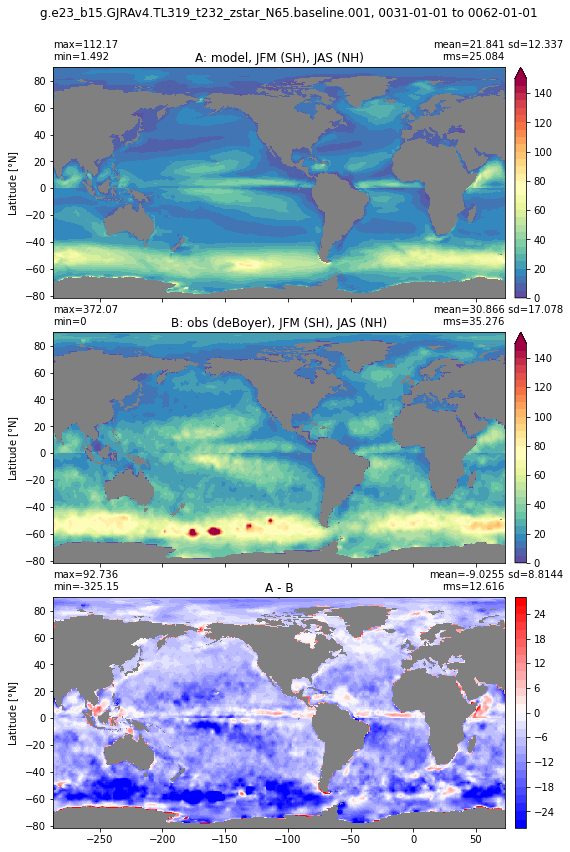

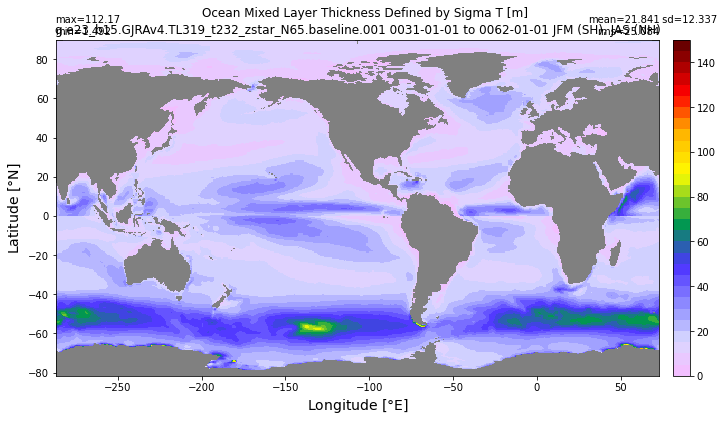

In [12]:
%matplotlib inline
# MLD
get_MLD(ds,'mlotst', mld_obs, grd, args)

### Boundary layer depth

Computing monthly BLD climatology...
Time elasped:  0:00:50.156589

 Plotting...


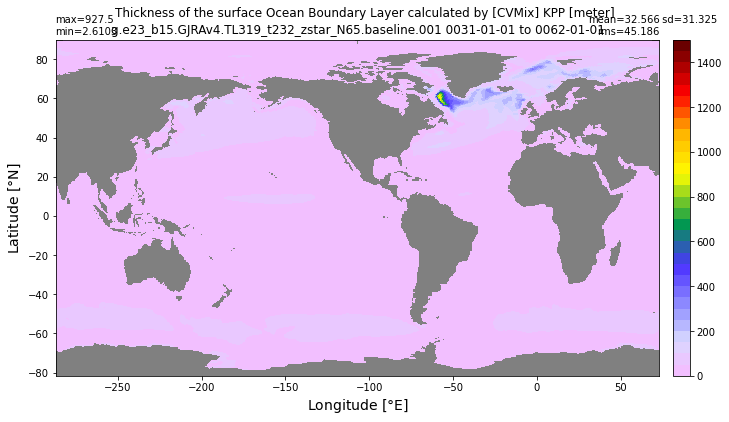

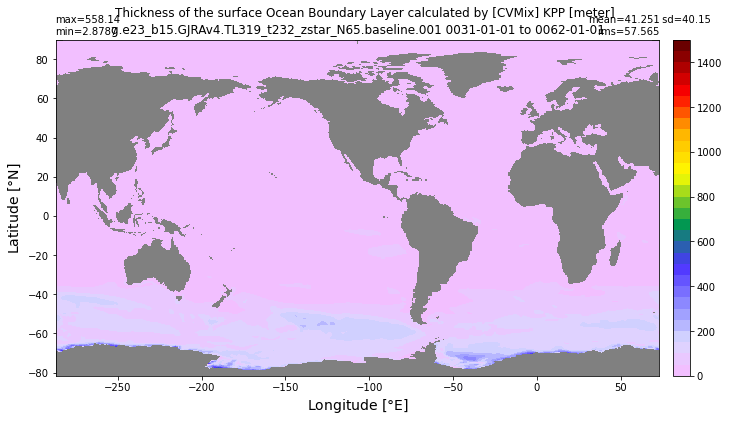

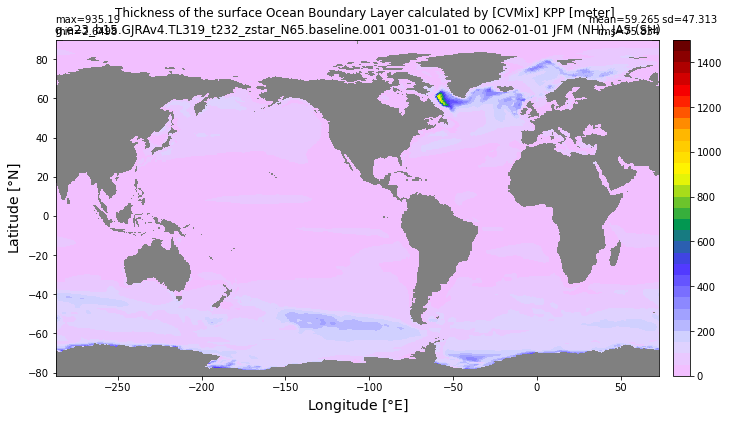

In [13]:
get_BLD(ds, 'oml', grd, args)

In [14]:
# SSH (not working)
#get_SSH(ds, 'SSH', grd, args)

In [15]:
if parallel:
    print('\n Releasing workers...')
    client.close(); cluster.close()


 Releasing workers...
